# Sensitivity analysis of the MONICA model for different soil types


Simulation scenarios

- Kursk, Barley, Sowing Date - 2022-05-02, Harvest date - 2022-09-01, N 51°43′52″ E 37°25′14″. 

- Soil type  - https://egrpr.esoil.ru/content/soils/soil119.html

In [1]:
import os, sys
import json
import pandas as pd
import datetime as dt
import subprocess
import csv
import math
import shutil
from tqdm import tqdm_notebook

from SALib.test_functions import Ishigami
from SALib import ProblemSpec

import seaborn as sns
import matplotlib.pyplot as plt


import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
os.environ['MONICA_PARAMETERS'] = "/run/monica/monica-parameters/"

## Prepare weather

In [3]:
df_weather = pd.read_csv('../pyCropModels/monica/monica_input/climate.csv', sep=';', header=1)

In [4]:
def csvdate_to_date(x, dateformat):
    """Converts string x to a datetime.date using given format.

    :param x: the string representing a date
    :param dateformat: a strptime() accepted date format
    :return: a date
    """
    dt_f = dt.datetime.strptime(str(x), dateformat)
    dt_p = dt.datetime.strftime(dt_f, '%d.%m.%Y')
    return dt_p


# Conversion functions
def NoConversion(x, d):
    return float(x)


def kJ_to_MJ(x, d):
    return float(x)/1000.


def mm_to_cm(x, d):
    return float(x)/10.


def kPa_to_hPa(x, d):
    return float(x)*10.


In [5]:
import datetime as dt
import numpy as np 
import os
import requests

from math import log10, cos, sin, asin, sqrt, exp, pi, radians

# from pcse.util import ea_from_tdew, reference_ET, check_angstromAB
class NASA_MONICA:
    ranges = {"LAT": (-90., 90.),
          "LON": (-180., 180.),
          "ELEV": (-300, 6000),
          "IRRAD": (0., 40e6),
          "TMIN": (-50., 60.),
          "TMAX": (-50., 60.),
          "VAP": (0.06, 199.3),  # hPa, computed as sat. vapour pressure at -50, 60 Celsius
          "RAIN": (0, 25),
          "E0": (0., 2.5),
          "ES0": (0., 2.5),
          "ET0": (0., 2.5),
          "WIND": (0., 100.),
          "SNOWDEPTH": (0., 250.),
          "TEMP": (-50., 60.),
          "TMINRA": (-50., 60.)}

    def __init__(self, latitude, longitude):
        if latitude < -90 or latitude > 90:
            msg = "Latitude should be between -90 and 90 degrees."
            raise ValueError(msg)
        if longitude < -180 or longitude > 180:
            msg = "Longitude should be between -180 and 180 degrees."
            raise ValueError(msg)

        self.MJ_to_J = lambda x: x * 1e6
        self.mm_to_cm = lambda x: x / 10.
        self.tdew_to_hpa = lambda x: ea_from_tdew(x) * 10.
        self.to_date = lambda d: d.date()
        self.HTTP_OK = 200
        self.angstA = 0.29
        self.angstB = 0.49

        self.latitude = latitude
        self.longitude = longitude

        self.power_variables = ["TOA_SW_DWN", "ALLSKY_SFC_SW_DWN", "T2M", "T2M_MIN",
                            "T2M_MAX", "T2MDEW", "WS2M", "PRECTOTCORR", 'RH2M']
        self._get_and_process_NASAPower(latitude, longitude)

    def _get_and_process_NASAPower(self, latitude, longitude):
            """Handles the retrieval and processing of the NASA Power data
            """
            powerdata = self._query_NASAPower_server(latitude, longitude)
            if not powerdata:
                msg = "Failure retrieving POWER data from server. This can be a connection problem with " \
                    "the NASA POWER server, retry again later."
                raise RuntimeError(msg)

            # Store the informational header then parse variables
            self.description = [powerdata["header"]["title"]]
            self.elevation = float(powerdata["geometry"]["coordinates"][2])
            
            
            df_power = self._process_POWER_records(powerdata)
#             self.angstA, self.angstB = self._estimate_AngstAB(df_power)
            df_monica = self._POWER_to_PCSE(df_power)
            self.df_monica = df_monica
            return df_monica
    def _query_NASAPower_server(self, latitude, longitude):
        start_date = dt.date(2022,1,1)
        end_date = dt.date(2023,1,1)
        # build URL for retrieving data, using new NASA POWER api
        server = "https://power.larc.nasa.gov/api/temporal/daily/point"
        payload = {"request": "execute",
                    "parameters": ",".join(self.power_variables),
                    "latitude": latitude,
                    "longitude": longitude,
                    "start": start_date.strftime("%Y%m%d"),
                    "end": end_date.strftime("%Y%m%d"),
                    "community": "AG",
                    "format": "JSON",
                    "user": "anonymous"
                    }
        req = requests.get(server, params=payload)

        if req.status_code != self.HTTP_OK:
            msg = ("Failed retrieving POWER data, server returned HTTP " +
                    "code: %i on following URL %s") % (req.status_code, req.url)
            raise ValueError(msg)

        return req.json()

    def _process_POWER_records(self, powerdata):
        """Process the meteorological records returned by NASA POWER
        """


        fill_value = float(powerdata["header"]["fill_value"])

        df_power = {}
        for varname in self.power_variables:
            s = pd.Series(powerdata["properties"]["parameter"][varname])
            s[s == fill_value] = np.NaN
            df_power[varname] = s
        df_power = pd.DataFrame(df_power)
        df_power["DAY"] = pd.to_datetime(df_power.index, format="%Y%m%d")

        # find all rows with one or more missing values (NaN)
        ix = df_power.isnull().any(axis=1)
        # Get all rows without missing values
        df_power = df_power[~ix]

        return df_power
    
    def _POWER_to_PCSE(self, df_power):

            # Convert POWER data to a dataframe with PCSE compatible inputs
            df_pcse = pd.DataFrame({"de-date": df_power.DAY.apply(self.to_date),
                                    "tavg": df_power.T2M,
                                    "tmin": df_power.T2M_MIN,
                                    "tmax": df_power.T2M_MAX,
                                    "wind": df_power.WS2M,
                                    "globrad": df_power.ALLSKY_SFC_SW_DWN,
                                    "precip": df_power.PRECTOTCORR,
                                    "relhumid": df_power.RH2M})
            df_pcse.loc[:, 'de-date'] = df_pcse.loc[:, 'de-date'].apply(lambda x: csvdate_to_date(x, '%Y-%m-%d'))
            self.df_pcse = df_pcse.reset_index(drop=True)
            return df_pcse
        


def round_geoposition(x, prec=1, base=.5):
    return round(base * round(float(x)/base),prec)

In [6]:
nasa_weather = NASA_MONICA(latitude = 51.5, longitude = 37.1)

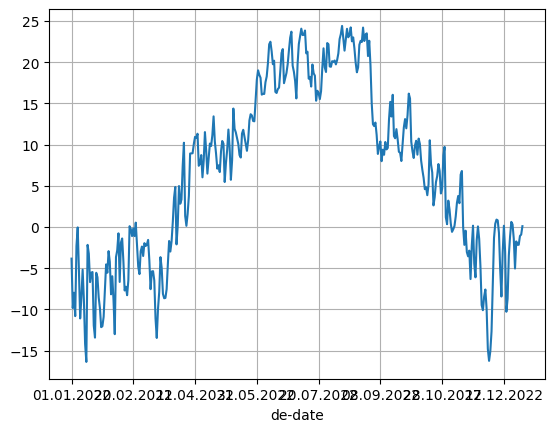

In [7]:
nasa_weather.df_monica.set_index('de-date')['tavg'].plot()
plt.grid()

In [8]:
## units for NASA POWER weather
# resp = requests.get(url='https://power.larc.nasa.gov/api/system/manager/parameters?community=ag&temporal=daily&metadata=false')
# units = resp.json()
# df_units = pd.DataFrame(units)

In [9]:
path = '../pyCropModels/monica/monica_input/'
fname = os.path.join(path, f'NASA_MONICA_Kshen.csv')
if not os.path.exists(fname):
    nasa_weather = NASA_MONICA(latitude = 51.5, longitude = 37.1)
    df_weather = nasa_weather.df_pcse
    df_weather.loc[:,'de-date'] = pd.to_datetime(df_weather.loc[:,'de-date'], format='%d.%m.%Y')
    r = pd.date_range(start=df_weather.loc[:,'de-date'].min(), end=df_weather.loc[:,'de-date'].max())
    full_range_weather = df_weather.set_index('de-date').reindex(r).rename_axis('de-date').reset_index()
    filled_weather = full_range_weather.fillna(method='ffill', axis=0)      
    filled_weather.loc[:, 'de-date'] = filled_weather.loc[:, 'de-date'].dt.strftime('%d.%m.%Y')
    filled_weather.to_csv(fname, sep=';',index=False)

## Compute crop 


In [10]:
cropsDict = {'barley':{'species':'crops/barley.json', 
                       'cultivar':'crops/barley/spring-barley.json',
                       'crop-residues':'crop-residues/barley.json'},
            'soybean':{'species':'crops/soybean.json', 
                       'cultivar':'crops/soybean/000.json',
                       'crop-residues':'crop-residues/soybean.json'},
            'maize':{'species':'crops/maize.json', 
                     'cultivar':'crops/maize/grain-maize-Pioneer-30K75.json',
                     'crop-residues':'crop-residues/maize.json'},
            'wheat':{'species':'crops/wheat.json',
                     'cultivar':'crops/wheat/spring-wheat.json',
                     'crop-residues':'crop-residues/wheat.json'}}

In [11]:
def get_real_soil():
    soil_layer_a1 = {'Thickness': [0.37, 'm'],
      'SoilOrganicCarbon': [5.1, '%'],
      'KA5TextureClass': 'Lu',
      'Sand': [0.037, 'kg kg-1 (%[0-1])'],
      'Clay': [0.09, 'kg kg-1 (%[0-1])'],
      'Skeleton': [0.02, '%[0-1]'],
      'PoreVolume': [0.566, 'm3 m-3'],
      'FieldCapacity': [0.3, 'm3 m-3'],
      'PermanentWiltingPoint': [0.15, 'm3 m-3'],
      'pH': [6.213],
      'CN': [12.481],
      'SoilBulkDensity': [1126.625, 'kg m-3']}
    
    
    soil_layer_b1 =  {'Thickness': [0.23, 'm'],
      'SoilOrganicCarbon': [2.38, '%'],
      'KA5TextureClass': 'Lu',
      'Sand': [0.066, 'kg kg-1 (%[0-1])'],
      'Clay': [0.13, 'kg kg-1 (%[0-1])'],
      'Skeleton': [0.02, '%[0-1]'],
      'PoreVolume': [0.401, 'm3 m-3'],
      'FieldCapacity': [0.3, 'm3 m-3'],
      'PermanentWiltingPoint': [0.15, 'm3 m-3'],
      'pH': [6.787],
      'CN': [10.139],
      'SoilBulkDensity': [1544.678, 'kg m-3']}
    
    
    soil_layer_b2 = {'Thickness': [1.30, 'm'],
      'SoilOrganicCarbon': [0.6, '%'],
      'KA5TextureClass': 'Lu',
      'Sand': [0.069, 'kg kg-1 (%[0-1])'],
      'Clay': [0.136, 'kg kg-1 (%[0-1])'],
      'Skeleton': [0.02, '%[0-1]'],
      'PoreVolume': [0.37, 'm3 m-3'],
      'FieldCapacity': [0.3, 'm3 m-3'],
      'PermanentWiltingPoint': [0.15, 'm3 m-3'],
      'pH': [8.013],
      'CN': [7.705],
      'SoilBulkDensity': [1599.873, 'kg m-3']}

    return [soil_layer_a1, soil_layer_b1, soil_layer_b2]

def prepareCrop(path:str, 
                crop_name:str,
                planting:str,
                harvest:str)-> dict:
    
    """
    Prepare crop dict for MONICA JSON file 
    
    """
    
    
    crop_file = os.path.join(path, 'crop.json')

    with open(crop_file, 'r') as j:
         cropJson = json.loads(j.read())

    #planting date
    cropJson['cropRotation'][0]['worksteps'][0]['date'] = planting
    # harvest date
    cropJson['cropRotation'][0]['worksteps'][1]['date'] = harvest
    for target in ['species', 'cultivar']:
        cropJson['cropRotation'][0]['worksteps'][0]['crop']\
                        ['cropParams'][target][1] = cropsDict[crop_name][target]
    cropJson['cropRotation'][0]['worksteps'][0]['crop']['residueParams'][1] = cropsDict[crop_name]['crop-residues']
    
    cropfName = os.path.join(path, 'crop-monica.json')
    with open(cropfName, 'w') as file: 
        json.dump(cropJson, file, ensure_ascii=False, indent=4)

    
    return cropJson

def prepareSite(path:str,
                latitude: float, soil:list = None)-> dict:
    """
    Prepare site dict for MONICA JSON file
    
    TO-DO: add soil data from soilgrids
    
    """

    site_file = os.path.join(path, 'site.json')

    with open(site_file, 'r') as j:
         siteJson = json.loads(j.read())
    siteJson['SiteParameters']['Latitude'] = latitude

    if soil is not None:
        siteJson['SiteParameters']['SoilProfileParameters'] = soil 
    sitefName = os.path.join(path, 'site-monica.json')
    with open(sitefName, 'w') as file: 
        json.dump(siteJson, file, ensure_ascii=False, indent=4)

    return siteJson

def get_yield_value_from_csv(csv_output: str):
    with open(csv_output, 'r') as f:
        reader = csv.reader(f)
        target_line_index = None
        for i, line in enumerate(reader):
            if 'Yield' in line and 'CM-count' in line:
                target_line_index = i + 2
            elif target_line_index is not None and i == target_line_index:
                return float(line[2])

cropsDict = {'barley':{'species':'crops/barley.json', 
                       'cultivar':'crops/barley/spring-barley.json',
                       'crop-residues':'crop-residues/barley.json'},
            'soybean':{'species':'crops/soybean.json', 
                       'cultivar':'crops/soybean/000.json',
                       'crop-residues':'crop-residues/soybean.json'},
            'maize':{'species':'crops/maize.json', 
                     'cultivar':'crops/maize/grain-maize-Pioneer-30K75.json',
                     'crop-residues':'crop-residues/maize.json'},
            'wheat':{'species':'crops/wheat.json',
                     'cultivar':'crops/wheat/spring-wheat.json',
                     'crop-residues':'crop-residues/wheat.json'}}




In [12]:
df_MONICA = pd.DataFrame(columns = ['lon', 
                                      'lat',
                                      'year', 
                                      'crop',
                                      'model_type',
                                      'yield_kg_ha'])



In [13]:
pathMONICA = '../pyCropModels/monica/monica_input/'
def run_monica(weather_fname: str, crop: str = 'barley'):
    model_type = 'MONICA'
    shutil.copy2(weather_fname,os.path.join(pathMONICA, "climate-monica.csv"))
    year = 2022
    cropCalendar = {'plant_day': '2022-05-02', 'harvest_day':'2022-09-01'}
    crop_res = prepareCrop(path = pathMONICA, 
                           crop_name = crop,
                           planting = cropCalendar['plant_day'],
                           harvest = cropCalendar['harvest_day'])
    soil = get_real_soil()
    site_res = prepareSite(path = pathMONICA, 
                           latitude=51.5,
                           soil=soil)

    path_sim_file = "/notebooks/pyCropModels/monica/monica_input/sim-monica.json"
    cmd = 'monica-run'    
    res_monica_run = subprocess.run([cmd, path_sim_file], universal_newlines=True)
    out_monica = pd.read_csv('./out.csv', skiprows=1, nrows=2)
    monica_yield = get_yield_value_from_csv('./out.csv')
    df = pd.read_csv('./out.csv', skiprows=[0,2], skipfooter=30, engine='python')
    return monica_yield, df
    

Запуск расчетов модели MONICA с погодой LARS-WG

In [14]:
def lars_to_monica(df:pd.DataFrame,reanalysis_year: pd.DataFrame, n: int = 1):
    # Columns for MONICA csv weather
    expected_columns = ['de-date', 'tavg', 'tmin', 'tmax', 'wind', 'globrad', 'precip','relhumid']
    # n - random sampled from 0 to 50
    mask = df['YEAR']==n

    # Sample one year for modelling
    df_year = df.loc[mask]
    df_year = df_year.reset_index()
    df_year.loc[:, 'tavg']=df_year[['MIN', 'MAX']].mean(axis=1)
    df_year = df_year.rename(columns={'MIN': 'tmin', 
                                      'MAX': 'tmax', 
                                      'RAD':'globrad',
                                      'RAIN':'precip',
                                     })
    df_year.loc[:, 'wind'] = reanalysis_year['wind']
    df_year.loc[:, 'relhumid'] = reanalysis_year['relhumid']
    df_year.loc[:, 'de-date'] = df_year['date'].dt.strftime('%d.%m.%Y')
    return df_year[expected_columns]


In [15]:
fname = os.path.join(pathMONICA,'NASA_MONICA_Kshen.csv')
reanalysis = pd.read_csv(fname, sep=';')

columns = ["YEAR", "JDAY", "MIN", "MAX", "RAIN","RAD"]

reanalysis_year = reanalysis.iloc[:365, :]


In [61]:
folder = '../pyCropModels/LARS-WG/LARS_KSHEN/'
files = os.listdir(folder)
columns = ["YEAR", "JDAY", "MIN", "MAX", "RAIN","RAD"]

reanalysis_year = reanalysis.iloc[:365, :]

climate_df = pd.DataFrame(columns=['climate-model', 'scenario', 'period', 'n',  'MONICA'])

for model in ["HadGEM3-GC31-LL", "CNRM-CM6-1"]:
    for scenario in ['ssp126', 'ssp585']:
        for period in ['2081-2100']:
            print(model, scenario, period)
            fname = f'LARS_KSHEN_{model}[LARS_KSHEN,{scenario},{period}]WG.dat'
            target = os.path.join(folder, fname)
            data = pd.read_csv(target, sep='\t', decimal=',', index_col=False, header=None, names=columns )
            data['date'] = pd.to_datetime(data['JDAY'].apply(lambda x: '2022-'+str(x)), format='%Y-%j')
            for n in range(1,21):
                print(n, end=' ')
                monica_lars_df = lars_to_monica(df=data, reanalysis_year=reanalysis_year, n=n)
                climate_fname = os.path.join(pathMONICA,'LARS_WG_MONICA.csv')
                monica_lars_df.to_csv(climate_fname, sep=';',index=False)
                monica_yield, df = run_monica(weather_fname=climate_fname, crop='wheat')
                row = [model, scenario, period, n, monica_yield]
                climate_df.loc[len(climate_df)] = row

                monica_yield, df = run_monica(weather_fname=climate_fname)

HadGEM3-GC31-LL ssp126 2081-2100
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 HadGEM3-GC31-LL ssp585 2081-2100
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 CNRM-CM6-1 ssp126 2081-2100
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 CNRM-CM6-1 ssp585 2081-2100
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 

In [62]:
fname = os.path.join(pathMONICA,'NASA_MONICA_Kshen.csv')
monica_yield, df = run_monica(weather_fname=fname)
row = ['Reanalysis', 'Current', '2022', 0,  monica_yield]
climate_df.loc[len(climate_df)] = row

In [21]:
!pip3 -q install scienceplots

In [23]:
import scienceplots
plt.style.use(['science' , 'no-latex'])

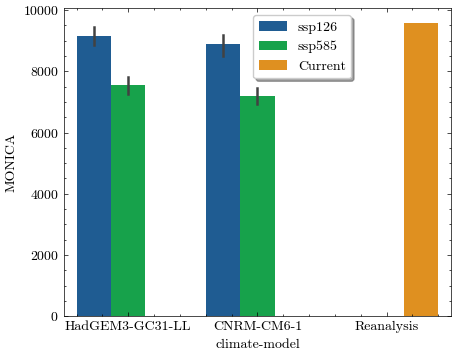

In [64]:
fig, ax = plt.subplots(1,1, figsize=(5,4))
sns.barplot(y='MONICA', x ='climate-model',  hue= 'scenario',  data=climate_df)
leg=ax.legend(frameon=True,           
           bbox_to_anchor=(0.76, 1.0),
           ncol=1,
           shadow=True,)
plt.savefig('../plots/future_climate_monica_wheat.png', dpi=300)

Plots for MONICA state variables dynamic

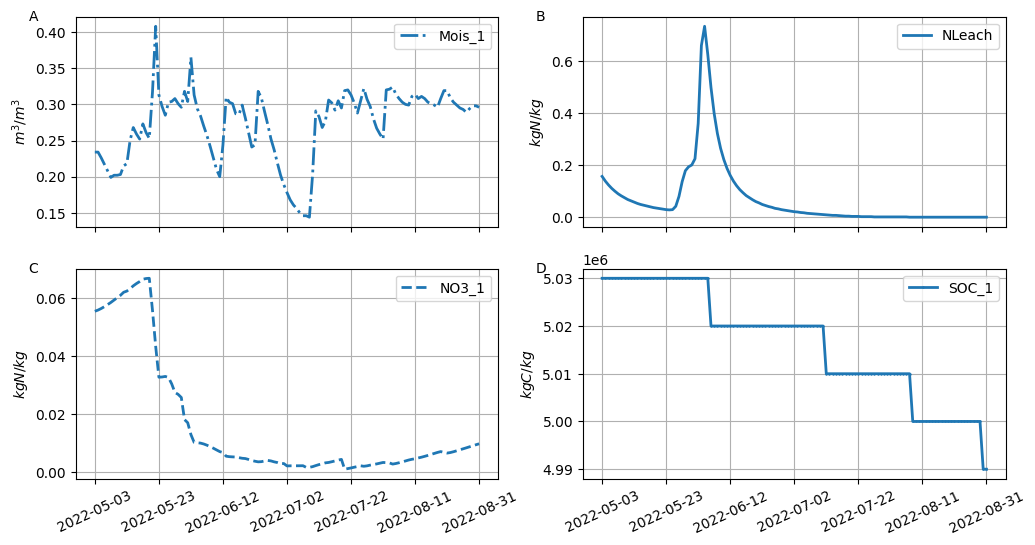

In [28]:
import matplotlib
lang = "EN"
variables = ['Yield', 'NEE', 'AbBiom', 'LAI']


names = {'Yield':"Урожай", 'NEE': "NEE", 'AbBiom':"Биомасса", 'LAI': "LAI"}
units = {'Yield':"$Урожайность,\ кг/га$", 'NEE': "$NEE,\ кг С/га$", 
         'AbBiom':"$Надземная\ биомасса,\ кг/га$", 'LAI': "$LAI,\ м^2/м^2$"}


units = {'Yield':"$кг/га$", 'NEE': "$кг С/га$", 
         'AbBiom':"$кг/га$", 'LAI': "$м^2/м^2$"}
variables = ['Mois_1', 'NLeach', "NO3_1",'SOC_1']

names = {'Mois_1':"Влажность почвы", 'NLeach': "Выщелачивание нитратов", 'NO3_1':"$NO_3$", 'SOC_1': "Орг. вещество"}
units = {'Mois_1':"$m^3/m^3$", 'NLeach': "$кг N/кг$",
         'NO3_1':"$кг N/кг$", 'SOC_1': "$кг С/кг$"}
styles = ['-.',  '-','--', '.-', '.-', '_']
fig, axes = plt.subplots(2,2,figsize = (12,6))

if lang == 'EN':
    plot_nums = {0:"A", 1:"B", 2:"C", 3:"D" }
    units = {'Mois_1':"$m^3/m^3$", 'NLeach': "$kg N/kg$",
         'NO3_1':"$kg N/kg$", 'SOC_1': "$kg С/kg$"}
else: 
    plot_nums = {0:"A", 1:"Б", 2:"В", 3:"Г" }
    units = {'Mois_1':"$м^3/м^3$", 'NLeach': "$кг N/кг$",
         'NO3_1':"$кг N/кг$", 'SOC_1': "$кг С/кг$"}
axes=axes.flatten()
cropCalendar = {'plant_day': '2022-05-02', 'harvest_day':'2022-09-01'}
for i, ax in enumerate(axes):
    df['SOC_1'] = df['SOC_1'] * 100
    select = df.loc[(df['Date']>cropCalendar['plant_day'])&(df['Date']<cropCalendar['harvest_day'])]
    soil = variables[i]

    select.set_index('Date')[soil].plot(style=styles[i],
                                        linewidth=2.0,
                                        ms=1.5, 
                                        label=soil, 
                                        ax=ax)
    ax.grid()
    ax.set_xlabel("")
    ax.set_ylabel(units[soil])
    ax.text(-0.1, 1., plot_nums[i], 
             horizontalalignment='center', 
             verticalalignment='center', transform=ax.transAxes)

#     if i==1:
    ax.legend(frameon=True)
    if i < 2:
        ax.xaxis.set_ticklabels([])
    ax.xaxis.set_tick_params(rotation=25)
# plt.savefig(f'../plots/soyabean_soil_{lang}.png', dpi=300)
plt.show()


## SA для MONICA

In [29]:
soil = get_real_soil()
soil_dict = {name: layer for name, layer in zip(['A','B', 'B2'], soil)}

In [30]:
def get_bounds(soil_layer: dict, soil_cols: list):
    soil_cols = ['SoilOrganicCarbon','Sand', 'Clay', 'SoilBulkDensity']
    lowers, uppers =[], []
    means = np.zeros(shape=(len(soil_cols)))
    for i, soil_param in enumerate(soil_cols):
        means[i]= soil_layer[soil_param][0]
    lowers = np.round(means*0.7, 4)
    uppers = np.round(means * 1.3, 4)
    df_bounds = pd.DataFrame(data=np.array([soil_cols, lowers, uppers]).T, columns = ['param', 'lower', 'upper'] )
    df_bounds = df_bounds.set_index('param')
    df_bounds = df_bounds.astype(float)
    while df_bounds.loc['Clay'].sum() > 1:
        df_bounds.loc['Clay', 'upper'] -= 0.01
    
    lower = df_bounds['lower'].values
    upper = df_bounds['upper'].values
    bounds = [[low, up] for low, up in zip(lower, upper)]
    return bounds

def evaluate_soil(soil: dict):

    
    site_res = prepareSite(path = pathMONICA, 
                       latitude=51.5,
                       soil=list(soil.values()))

    path_sim_file = "/notebooks/pyCropModels/monica/monica_input/sim-monica.json"
    cmd = 'monica-run'    
    res_monica_run = subprocess.run([cmd, path_sim_file], universal_newlines=True)

    crop_yield = get_yield_value_from_csv('./out.csv')
    return crop_yield


def conduct_sensitivity(soil=soil, soil_horizon:str='A'):

    soil_cols = ['SoilOrganicCarbon','Sand', 'Clay', 'SoilBulkDensity']
    
    
    bounds = get_bounds(soil_layer=soil[soil_horizon], soil_cols=soil_cols)
    
    sp = ProblemSpec({
            "names": soil_cols,
            "groups": None,
            "bounds": bounds,
            "outputs": ["Y"],
        })
    
    sp.sample_sobol(32)
    
    
    Y = np.zeros([sp.samples.shape[0]])
    print(Y.shape)
    for i, X in tqdm_notebook(enumerate(sp.samples)):
        for i, key in enumerate(soil_cols):
            soil[soil_horizon][key] = X[i]
        Y[i] = evaluate_soil(X, soil=soil,
                             soil_cols=soil_cols)
    
    
    sp.set_results(Y)
    sp.analyze_sobol()
    total_Si, first_Si, second_Si = sp.to_df()
    return total_Si, first_Si, second_Si

In [59]:
model_type = 'MONICA'
pathMONICA = '../pyCropModels/monica/monica_input/'
crop = 'barley'
fname = os.path.join(pathMONICA,'NASA_MONICA_Kshen.csv')
shutil.copy2(fname,os.path.join(pathMONICA, "climate-monica.csv"))
year = 2022
cropCalendar = {'plant_day': '2022-05-02', 'harvest_day':'2022-09-01'}
crop_res = prepareCrop(path = pathMONICA, 
                       crop_name = crop,
                       planting = cropCalendar['plant_day'],
                       harvest = cropCalendar['harvest_day'])
soil = get_real_soil()

soil = {name: layer for name, layer in zip(['A','B', 'B2'], soil)}

soil_horizon='A'

soil_cols = ['SoilOrganicCarbon','Sand', 'Clay', 'SoilBulkDensity']


bounds = get_bounds(soil_layer=soil[soil_horizon], soil_cols=soil_cols)

sp = ProblemSpec({
        "names": soil_cols,
        "groups": None,
        "bounds": bounds,
        "outputs": ["Y"],
    })

sp.sample_saltelli(256)

Y = np.zeros([sp.samples.shape[0]])
print(Y.shape)
for i, X in tqdm_notebook(enumerate(sp.samples)):
    for j, key in enumerate(soil_cols):
        soil[soil_horizon][key] = X[j]
    Y[i] = evaluate_soil(soil=soil)


sp.set_results(Y)
sp.analyze_sobol()
total_Si, first_Si, second_Si = sp.to_df()

NameError: name 'get_bounds' is not defined

In [33]:
sp['names'] = ['SOC', 'Sand', 'Clay', 'BD']

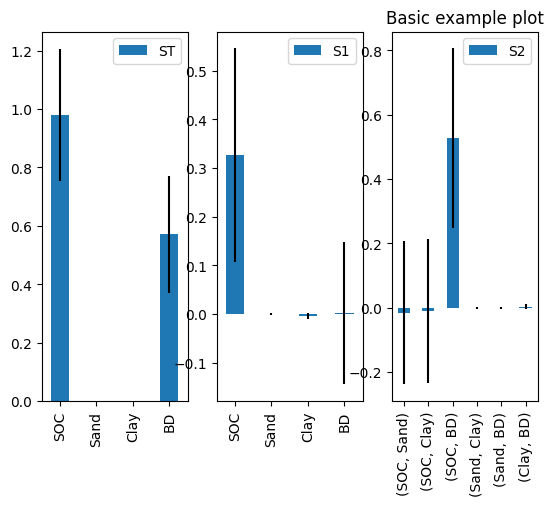

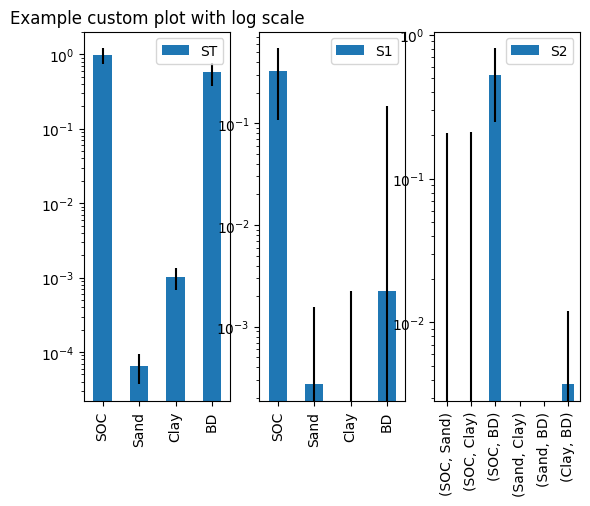

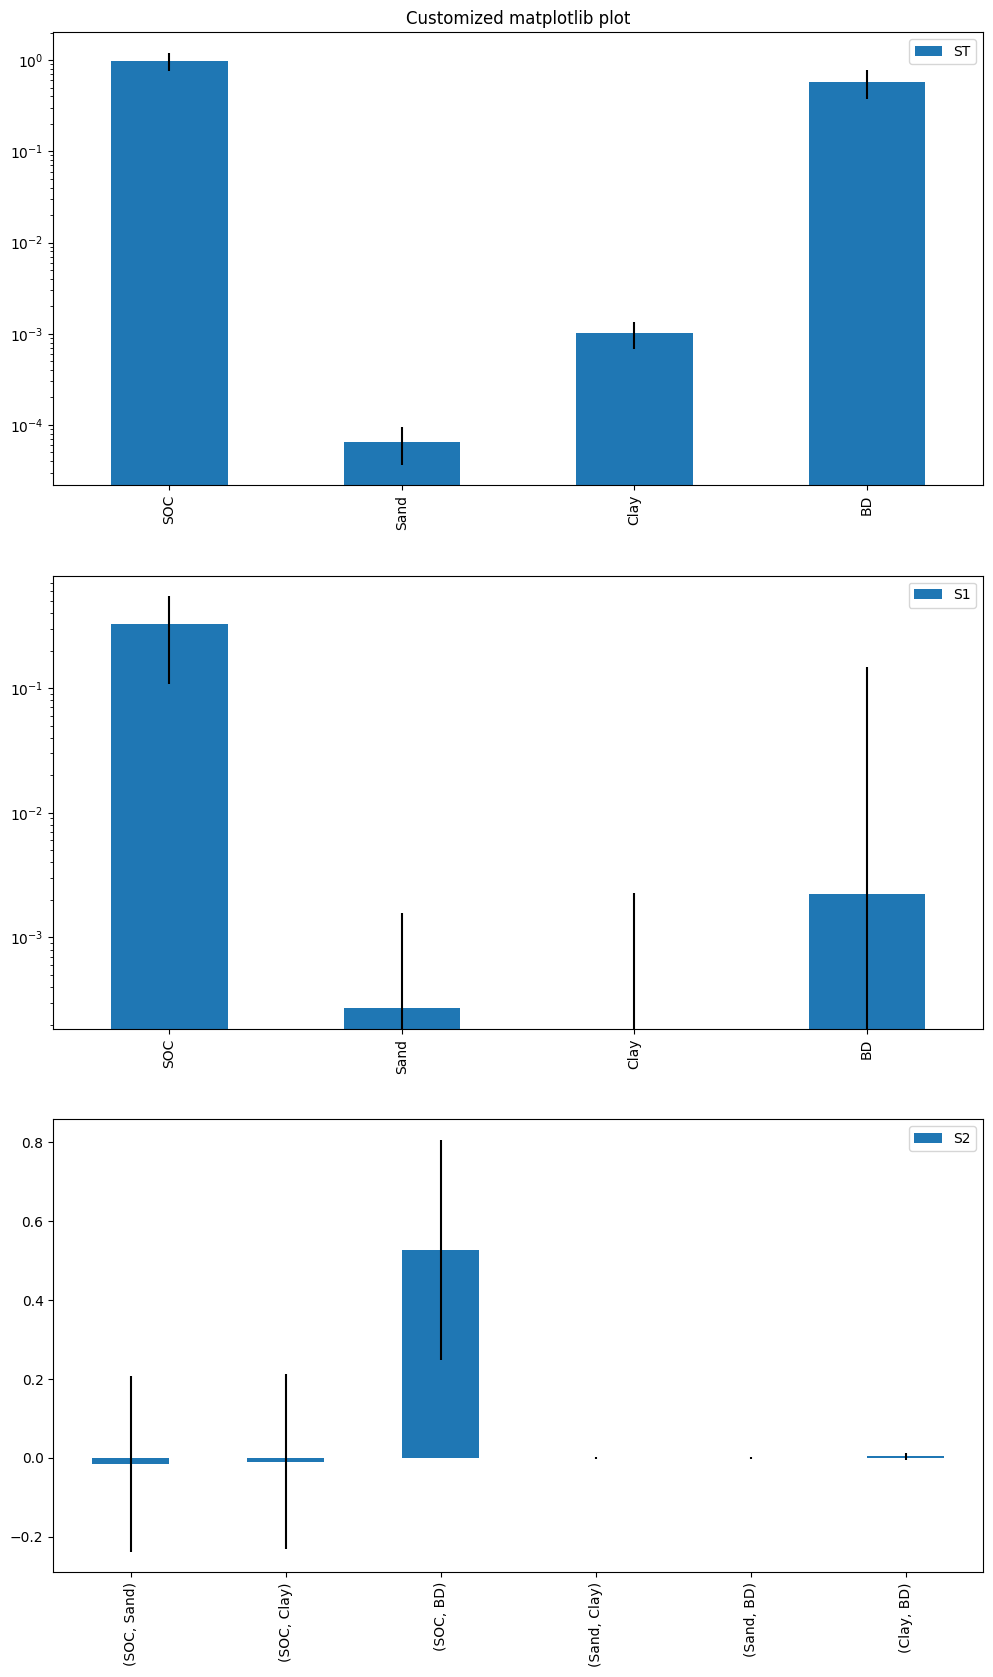

AttributeError: 'ProblemSpec' object has no attribute 'heatmap'

In [34]:

from SALib import plotting
from SALib.plotting.bar import plot as barplot

# Basic plotting of results

sp.plot()

plt.title("Basic example plot")


# More advanced plotting

# Plot functions actually return matplotlib axes objects
# In the case of the Sobol' method if `calc_second_order=True`, there will be
# 3 axes (one each for Total, First, and Second order indices)
axes = sp.plot()

# These can be modified as desired.
# Here, for example, we set the Y-axis to log scale
for ax in axes:
    ax.set_yscale("log")

axes[0].set_title("Example custom plot with log scale")

# Other custom layouts can be created in the usual matplotlib style
# with the basic bar plotter.

# Example: Direct control of plot elements
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 20))

# Get result DataFrames
total, first, second = sp.to_df()

ax1 = barplot(total, ax=ax1)
ax2 = barplot(first, ax=ax2)
ax3 = barplot(second, ax=ax3)

ax1.set_yscale("log")
ax2.set_yscale("log")

ax1.set_title("Customized matplotlib plot")
plt.show()


# Plot sensitivity indices as a heatmap
# Note that plotting methods return a matplotlib axes object
ax = sp.heatmap("Y")
ax.set_title("Basic heatmap")
plt.show()


# Another heatmap plot with more fine-grain control
# Displays Total and First-Order sensitivities in separate subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))
sp.heatmap("Y", "ST", "Total Order Sensitivity", ax1)
sp.heatmap("Y", "S1", "First Order Sensitivity", ax2)
plt.show()


# Yet another heatmap example
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(
    2, 2, figsize=(10, 6), sharex=True, constrained_layout=True
)
sp.heatmap("Y", "ST", "Total Order", ax=ax1)
sp.heatmap("Y", "ST_conf", "Total Order Conf.", ax=ax2)
sp.heatmap("Y", "S1", "First Order", ax=ax3)
sp.heatmap("Y", "S1_conf", "First Order Conf.", ax=ax4)
plt.show()

In [37]:
df_sensitivity = pd.DataFrame({
    "Parameter": sp["names"],
    "First_order": Si["S1"],
    "Total_order": Si["ST"]}).set_index("Parameter")

NameError: name 'Si' is not defined

In [40]:
total_Si, first_Si, second_Si = sp.to_df()

In [49]:
first_Si

,S1,S1_conf
SoilOrganicCarbon,0.412626,0.088353
Sand,0.000212,0.001157
Clay,-0.001069,0.003099
SoilBulkDensity,0.568231,0.121896


In [42]:
first_Si

,S1,S1_conf
SOC,0.326686,0.218870
Sand,0.000272,0.001300
Clay,-0.003686,0.005955
BD,0.002227,0.146230


In [50]:
total_Si

,ST,ST_conf
SoilOrganicCarbon,0.435173,0.069471
Sand,0.000035,0.000014
Clay,0.000398,0.000096
SoilBulkDensity,0.572564,0.104917


In [41]:
total_Si

,ST,ST_conf
SOC,0.979260,0.225440
Sand,0.000065,0.000029
Clay,0.001010,0.000336
BD,0.570906,0.200560


## Climate SA

In [43]:

fname = os.path.join(pathMONICA,'NASA_MONICA_Kshen.csv')
reanalysis = pd.read_csv(fname, sep=';')

columns = ["YEAR", "JDAY", "MIN", "MAX", "RAIN","RAD"]

reanalysis_year = reanalysis.iloc[:365, :]

folder = '../src/LARS-WG/LARS_KSHEN/'

model = 'HadGEM3-GC31-LL'
scenario = 'ssp585'
period = '2081-2100'
fname = f'LARS_KSHEN_{model}[LARS_KSHEN,{scenario},{period}]WG.dat'
target = os.path.join(folder, fname)
data = pd.read_csv(target, sep='\t', decimal=',', index_col=False, header=None, names=columns )
data['date'] = pd.to_datetime(data['JDAY'].apply(lambda x: '2022-'+str(x)), format='%Y-%j')
monica_lars_df = lars_to_monica(df=data, reanalysis_year=reanalysis_year, n=1)
climate_fname = os.path.join(pathMONICA,'LARS_WG_MONICA.csv')
monica_lars_df.to_csv(climate_fname, sep=';',index=False)

FileNotFoundError: [Errno 2] No such file or directory: '../src/LARS-WG/LARS_KSHEN/LARS_KSHEN_HadGEM3-GC31-LL[LARS_KSHEN,ssp585,2081-2100]WG.dat'

In [45]:
model_type = 'MONICA'
pathMONICA = '../pyCropModels/monica/monica_input/'
crop = 'barley'

shutil.copy2(climate_fname,os.path.join(pathMONICA, "climate-monica.csv"))
year = 2022
cropCalendar = {'plant_day': '2022-05-02', 'harvest_day':'2022-09-01'}
crop_res = prepareCrop(path = pathMONICA, 
                       crop_name = crop,
                       planting = cropCalendar['plant_day'],
                       harvest = cropCalendar['harvest_day'])
soil = get_real_soil()

soil = {name: layer for name, layer in zip(['A','B', 'B2'], soil)}

soil_horizon='A'

soil_cols = ['SoilOrganicCarbon','Sand', 'Clay', 'SoilBulkDensity']


bounds = get_bounds(soil_layer=soil[soil_horizon], soil_cols=soil_cols)

sp = ProblemSpec({
        "names": soil_cols,
        "groups": None,
        "bounds": bounds,
        "outputs": ["Y"],
    })

sp.sample_saltelli(256)


Y = np.zeros([sp.samples.shape[0]])
print(Y.shape)
for i, X in tqdm_notebook(enumerate(sp.samples)):
    for j, key in enumerate(soil_cols):
        soil[soil_horizon][key] = X[j]
    Y[i] = evaluate_soil(soil=soil)


sp.set_results(Y)
sp.analyze_sobol()
total_Si, first_Si, second_Si = sp.to_df()

(2560,)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


0it [00:00, ?it/s]

In [46]:
total_Si, first_Si, second_Si = sp.to_df()

In [48]:
first_Si

,S1,S1_conf
SoilOrganicCarbon,0.412626,0.088353
Sand,0.000212,0.001157
Clay,-0.001069,0.003099
SoilBulkDensity,0.568231,0.121896


In [47]:
total_Si

,ST,ST_conf
SoilOrganicCarbon,0.435173,0.069471
Sand,0.000035,0.000014
Clay,0.000398,0.000096
SoilBulkDensity,0.572564,0.104917


In [71]:
sp['names'] = ['SOC', 'Sand', 'Clay', 'BD']

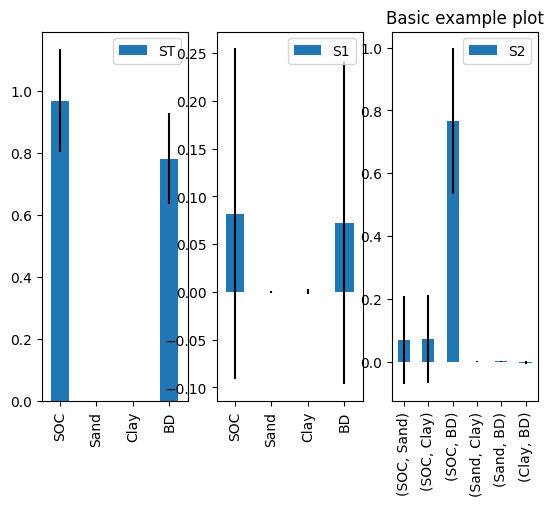

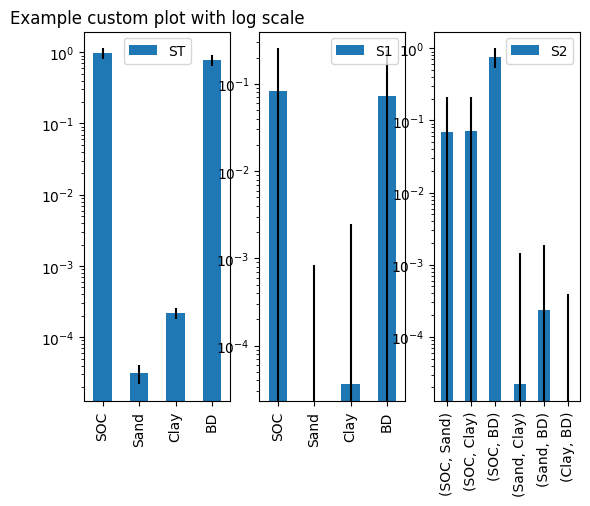

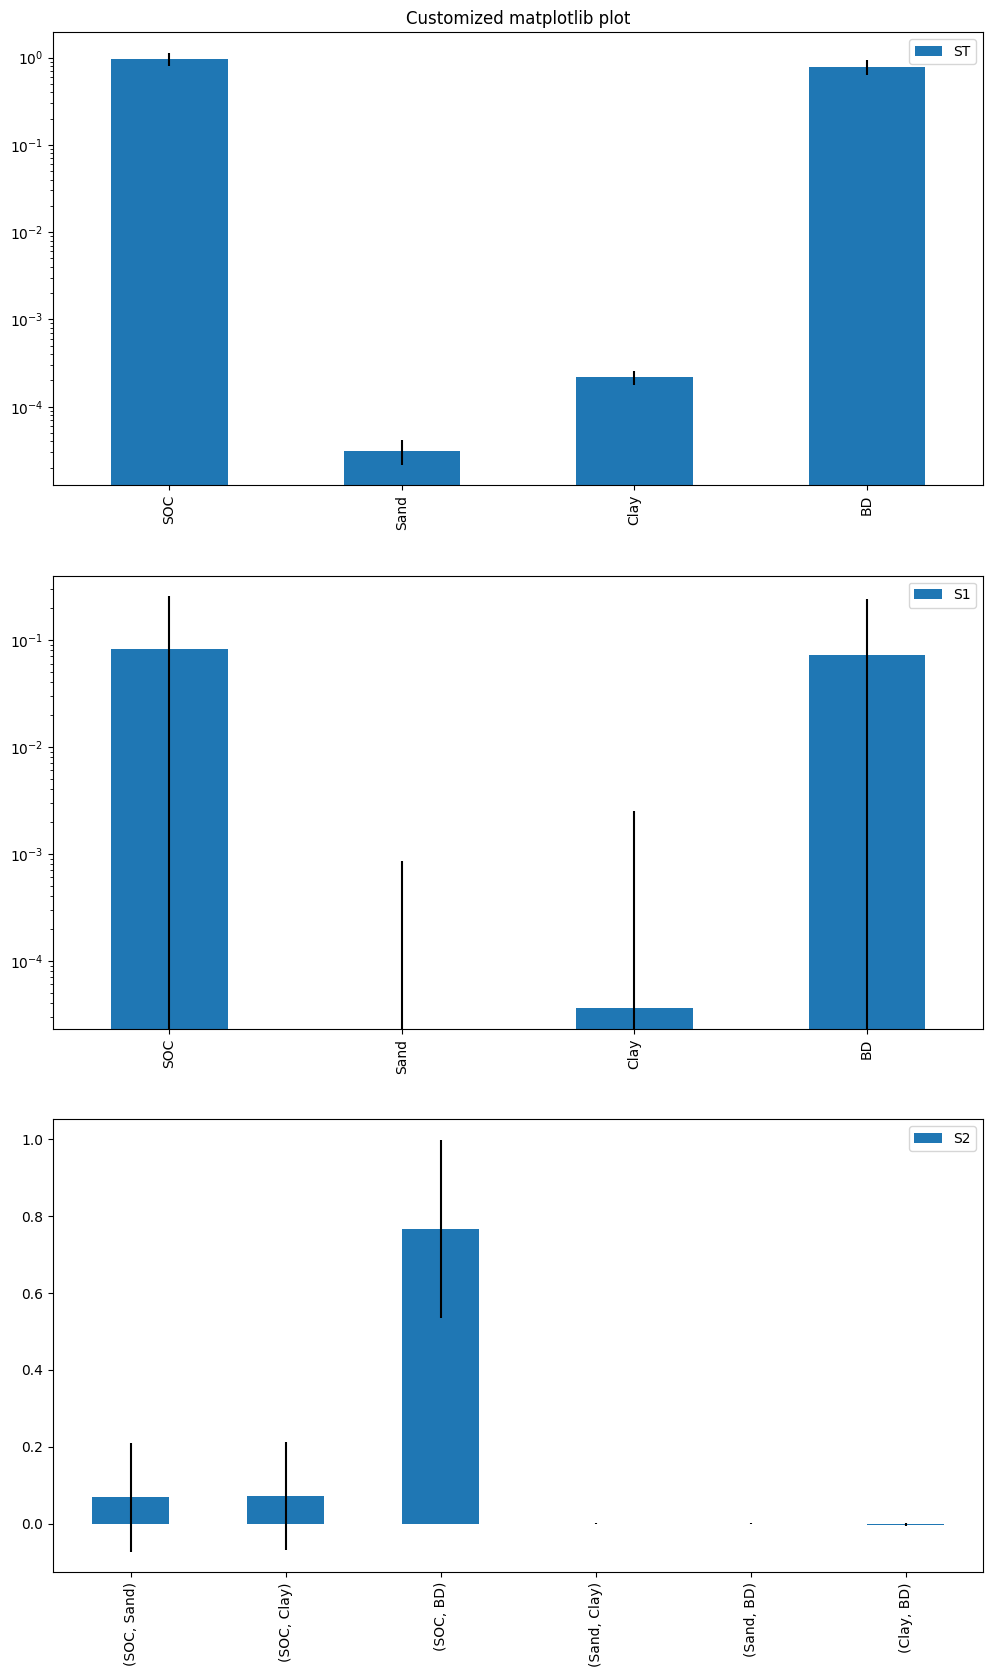

AttributeError: 'ProblemSpec' object has no attribute 'heatmap'

In [72]:

from SALib import plotting
from SALib.plotting.bar import plot as barplot

# Basic plotting of results

sp.plot()

plt.title("Basic example plot")


# More advanced plotting

# Plot functions actually return matplotlib axes objects
# In the case of the Sobol' method if `calc_second_order=True`, there will be
# 3 axes (one each for Total, First, and Second order indices)
axes = sp.plot()

# These can be modified as desired.
# Here, for example, we set the Y-axis to log scale
for ax in axes:
    ax.set_yscale("log")

axes[0].set_title("Example custom plot with log scale")

# Other custom layouts can be created in the usual matplotlib style
# with the basic bar plotter.

# Example: Direct control of plot elements
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 20))

# Get result DataFrames
total, first, second = sp.to_df()

ax1 = barplot(total, ax=ax1)
ax2 = barplot(first, ax=ax2)
ax3 = barplot(second, ax=ax3)

ax1.set_yscale("log")
ax2.set_yscale("log")

ax1.set_title("Customized matplotlib plot")
plt.show()


# Plot sensitivity indices as a heatmap
# Note that plotting methods return a matplotlib axes object
ax = sp.heatmap("Y")
ax.set_title("Basic heatmap")
plt.show()


# Another heatmap plot with more fine-grain control
# Displays Total and First-Order sensitivities in separate subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))
sp.heatmap("Y", "ST", "Total Order Sensitivity", ax1)
sp.heatmap("Y", "S1", "First Order Sensitivity", ax2)
plt.show()


# Yet another heatmap example
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(
    2, 2, figsize=(10, 6), sharex=True, constrained_layout=True
)
sp.heatmap("Y", "ST", "Total Order", ax=ax1)
sp.heatmap("Y", "ST_conf", "Total Order Conf.", ax=ax2)
sp.heatmap("Y", "S1", "First Order", ax=ax3)
sp.heatmap("Y", "S1_conf", "First Order Conf.", ax=ax4)
plt.show()

In [ ]:
%load_ext heat

In [ ]:
from collections import deque
from io import StringIO

with open('./out.csv', 'r') as f:
    q = deque(f, 20)  
    df_yield =float(pd.read_csv(StringIO(''.join(q)), header=None).iloc[4,2])

In [ ]:
def evaluate_soil():
    path_sim_file = 'monica_run.sh'
    cmd_monica = 'bash'

    res_monica_run = subprocess.run([cmd_monica, path_sim_file], universal_newlines=True)
    with open('./out.csv', 'r') as f:
        q = deque(f, 20)  
        crop_yield =float(pd.read_csv(StringIO(''.join(q)), header=None).iloc[4,2])
    return crop_yield
evaluate_soil()

9600.3

In [ ]:
%timeit  evaluate_soil()

377 ms ± 19.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
def evaluate_soil():
    path_sim_file = 'monica_run.sh'
    cmd_monica = 'bash'
    res_monica_run = subprocess.run([cmd_monica, path_sim_file], universal_newlines=True)
    df_yield = pd.read_csv('./out.csv', skiprows=1183, skipfooter=13, engine='python')
    crop_yield = float(df_yield.loc[1,'Yield'])
    return crop_yield

In [ ]:
%timeit evaluate_soil()

399 ms ± 42.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


/home/mgasanov/anaconda3/envs/assimilation/lib/python3.8/site-packages/pyheat/pyheat.py:158: UserWarning: FixedFormatter should only be used together with FixedLocator
  self.ax.set_yticklabels(row_labels, minor=False)


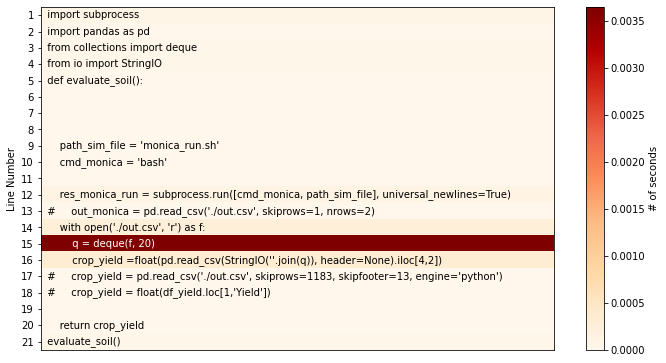

In [ ]:
%%heat 
import subprocess
import pandas as pd
from collections import deque
from io import StringIO
def evaluate_soil():



    path_sim_file = 'monica_run.sh'
    cmd_monica = 'bash'

    res_monica_run = subprocess.run([cmd_monica, path_sim_file], universal_newlines=True)
#     out_monica = pd.read_csv('./out.csv', skiprows=1, nrows=2)
    with open('./out.csv', 'r') as f:
        q = deque(f, 20)  
        crop_yield =float(pd.read_csv(StringIO(''.join(q)), header=None).iloc[4,2])
#     crop_yield = pd.read_csv('./out.csv', skiprows=1183, skipfooter=13, engine='python')
#     crop_yield = float(df_yield.loc[1,'Yield'])

    return crop_yield
evaluate_soil()

/home/mgasanov/anaconda3/envs/assimilation/lib/python3.8/site-packages/pyheat/pyheat.py:158: UserWarning: FixedFormatter should only be used together with FixedLocator
  self.ax.set_yticklabels(row_labels, minor=False)


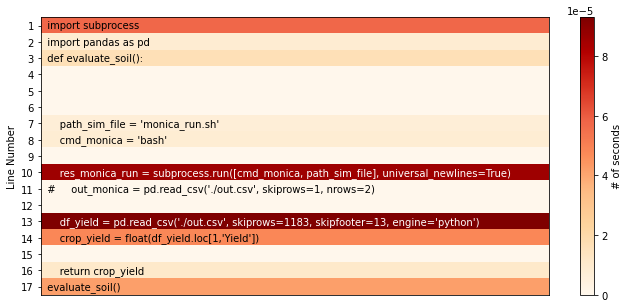

In [ ]:
%%heat 
import subprocess
import pandas as pd
def evaluate_soil():



    path_sim_file = 'monica_run.sh'
    cmd_monica = 'bash'

    res_monica_run = subprocess.run([cmd_monica, path_sim_file], universal_newlines=True)
#     out_monica = pd.read_csv('./out.csv', skiprows=1, nrows=2)

    df_yield = pd.read_csv('./out.csv', skiprows=1183, skipfooter=13, engine='python')
    crop_yield = float(df_yield.loc[1,'Yield'])

    return crop_yield
evaluate_soil()